In [13]:
import os
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
import keras
from tensorflow.keras import layers
import keras_tuner

In [2]:
files = os.listdir('../final_stats/preprocessed_3/')
no_sent_files = files[:7]

### File Retrieval and Preprocessing

In [4]:
def split_target(df, target_col='away_winner_wts'):
    df = df.copy()
    target = df.pop(target_col)
    return df, target

def normalize_df(df):
    scaler = StandardScaler()
    data, target = split_target(df)
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    return data, target

def get_data(file):
    df = pd.read_csv(f'../final_stats/preprocessed_3/{file}', index_col=[0])
    data, target = normalize_df(df)
    return data, target

def shuffle_data(x,y, seed):
    x_shuffle = x.sample(frac=1, random_state=seed)
    y_shuffle = y.sample(frac=1, random_state=seed)
    return x_shuffle, y_shuffle


### Chart Code

In [26]:
def get_average_acc_history(acc_histories):
    num_epochs = len(acc_histories[0])
    return [np.mean([x[i] for x in acc_histories]) for i in range(num_epochs)]

def get_average_loss_history(loss_histories):
    num_epochs = len(loss_histories[0])
    return [np.mean([x[i] for x in loss_histories]) for i in range(num_epochs)]
        
def plot_ave_acc_and_loss_histories(acc_histories, loss_histories):
    average_acc_history = get_average_acc_history(acc_histories)
    average_loss_history = get_average_loss_history(loss_histories)

    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")

    plt.subplot(1, 2, 2)

    plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.show()

def compare_ave_loss_acc_histories(acc_hist_1, acc_hist_2, loss_hist_1, loss_hist_2):
    min_epochs = min(len(acc_hist_1[0]), len(acc_hist_2[0]))
    
    ave_acc_hist_1 = get_average_acc_history(acc_hist_1)
    ave_loss_hist_1 = get_average_loss_history(loss_hist_1)
    
    ave_acc_hist_2 = get_average_acc_history(acc_hist_2)
    ave_loss_hist_2 = get_average_loss_history(loss_hist_2)


    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    epochs = range(1, min_epochs + 1)
    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, ave_acc_hist_1, solid_blue_line, label='Model 1')
    plt.plot(epochs, ave_acc_hist_2, solid_red_line, label='Model 2')
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(epochs, ave_loss_hist_1, solid_blue_line, label='Model 1')
    plt.plot(epochs, ave_loss_hist_2, solid_red_line, label='Model 2')
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.legend()
    
    plt.show()
    

### Base model

### K-Fold Cross Validation


#### Option 1 - Base sklearn Pandas example

In [24]:


def split_target(df, target_col='away_winner_wts'):
    df = df.copy()
    target = df.pop(target_col)
    return df, target

def normalize_df(df):
    scaler = StandardScaler()
    data, target = split_target(df)
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    return data, target

def get_data(file):
    df = pd.read_csv(f'../final_stats/preprocessed_3/{file}', index_col=[0])
    data, target = normalize_df(df)
    return data, target


In [25]:
def get_max_ave_acc_min_ave_loss(acc_histories, loss_histories):
    num_epochs = len(acc_histories[0])
    average_acc_history = [
        np.mean([x[i] for x in acc_histories]) for i in range(num_epochs)
    ]
    index_acc = np.argmax(average_acc_history)
    max_acc = round(average_acc_history[index_acc]*100,2)
    print(f'\nMax Average Accuracy: {max_acc}% \t Num Epochs: {index_acc + 1} ')

    average_loss_history = [
        np.mean([x[i] for x in loss_histories]) for i in range(num_epochs)
    ]
    index_loss = np.argmin(average_loss_history)
    min_loss = round(average_loss_history[index_loss], 2)
    print(f'Min Average Loss: {min_loss} \t Num Epochs: {index_loss + 1} ')
    return

### Fresh look at this

In [36]:
def get_val_and_train(data, i, num_val_samples):
    val = data[i * num_val_samples: (i + 1) * num_val_samples]
    train = np.concatenate(
                    [data[:i * num_val_samples],
                    data[(i + 1) * num_val_samples:]],
                    axis=0
                )
    return val, train


def run_k_fold(x, y, build_m, num_epochs=30, k=10, n_repeats=10):
    num_val_samples = len(x) // k
    all_scores = [] 
    
    all_histories = []
    acc_histories = []
    loss_histories = []
    curr_fold = 0
    total_folds = k*n_repeats
    # cv = RepeatedKFold(10, 10, 99)
    for n in range(n_repeats):
        xs, ys = shuffle_data(x,y,n)
        for i in range(k):
            curr_fold = curr_fold + 1
            if curr_fold % 10 == 0:
                print(f"Fold {curr_fold}/{total_folds}")
 
            X_val, X_train = get_val_and_train(xs, i, num_val_samples)
            y_val, y_train = get_val_and_train(ys, i, num_val_samples)

            model = build_m()
            
            history = model.fit(
                    X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=num_epochs, batch_size=16, verbose=0
                )
            
            all_histories.append(history.history)
            acc_histories.append(history.history['val_accuracy'])
            loss_histories.append(history.history['val_loss'])

    get_max_ave_acc_min_ave_loss(acc_histories, loss_histories)
    plot_ave_acc_and_loss_histories(acc_histories, loss_histories)
    return [all_histories, acc_histories, loss_histories]

RMS Default (1e-3): 56.8%
RMS 1e-4: 51.5%
Adam 1e-4: 49.9%
Adam 1e-3: 54.3%

### Keras Tune Build Model

In [100]:
def build_model_2(hp):
    model = keras.Sequential()
    # dense layers
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(
            layers.Dense(
                units= hp.Int(f'units_{i}', min_value=16, max_value=2048, step=32),
                activation= hp.Choice('activation', ['relu','tanh'])
            )   
        )
        if hp.Boolean('dropout'):
            model.add(layers.Dropout(
                rate=hp.Float('do_rate', min_value=0.1, max_value=0.8, step=0.1)
                )
            )
    # dropout layer
    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    #learning rate
    learning_rate = hp.Float('lr', min_value=1e-5, max_value=1e-1, sampling='log')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )

    return model

build_model_2(keras_tuner.HyperParameters())

#### Create Tuner

In [101]:
x, y = get_data(files[0])  # NumPy data

tuner = keras_tuner.RandomSearch(
    hypermodel = build_model_2,
    objective='val_accuracy',
    max_trials=500,
    executions_per_trial=3, # how many times to try the same combination of hps
    overwrite=True,
    directory='./nn_models',
)
tuner.search_space_summary()
# tuner.search(x, y, batch_size=64, epochs=30)

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 2048, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


#### Split data for Test and Train

In [102]:
x,y = get_data(files[0])
X_val, X_train = get_val_and_train(x, 1, num_val_samples = len(x) // 5)
y_val, y_train = get_val_and_train(y, 1, num_val_samples = len(x) // 5)


#### Run Search

In [103]:
tuner.search(
    X_train, 
    y_train, 
    epochs=30, 
    batch_size=64, 
    validation_data=(X_val, y_val)
)

Trial 500 Complete [00h 00m 19s]
val_accuracy: 0.6507936716079712

Best val_accuracy So Far: 0.7777777910232544
Total elapsed time: 02h 11m 16s
INFO:tensorflow:Oracle triggered exit


#### Search Results

In [109]:
tuner.results_summary()

Results summary
Results in ./nn_models\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 9
units_0: 656
activation: tanh
dropout: True
lr: 0.0039062177493685967
units_1: 720
units_2: 1168
units_3: 400
units_4: 1072
do_rate: 0.2
units_5: 560
units_6: 592
units_7: 1968
units_8: 1040
units_9: 1520
Score: 0.7777777910232544
Trial summary
Hyperparameters:
num_layers: 9
units_0: 1328
activation: relu
dropout: True
lr: 9.486902167151127e-05
units_1: 272
units_2: 720
units_3: 1552
units_4: 1008
do_rate: 0.2
units_5: 976
units_6: 1168
units_7: 560
units_8: 496
Score: 0.7301587462425232
Trial summary
Hyperparameters:
num_layers: 9
units_0: 1392
activation: tanh
dropout: True
lr: 0.000294920699630526
units_1: 752
units_2: 400
units_3: 1008
units_4: 1616
do_rate: 0.2
units_5: 2000
units_6: 1328
units_7: 816
units_8: 880
units_9: 208
Score: 0.7301587462425232
Trial summary
Hyperparameters:
num_layers: 2
units_0: 752
activation: tanh
dropout: False
lr: 0.025233293999

#### Get Best Model Summary

In [105]:
models = tuner.get_best_models(2)
best_model = models[0]
best_model.build(input_shape = (82,142))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (82, 656)                 93808     
                                                                 
 dropout (Dropout)           (82, 656)                 0         
                                                                 
 dense_1 (Dense)             (82, 720)                 473040    
                                                                 
 dropout_1 (Dropout)         (82, 720)                 0         
                                                                 
 dense_2 (Dense)             (82, 1168)                842128    
                                                                 
 dropout_2 (Dropout)         (82, 1168)                0         
                                                                 
 dense_3 (Dense)             (82, 400)                 4

#### Get Best HyperParams

In [131]:
# get best hps
best_hps = tuner.get_best_hyperparameters(5)
# model_best = build_model_2(best_hps[0])

#### Repeated KFold Using Best HPs

In [128]:
def run_k_fold_hps(x, y, build_m, hps, num_epochs=30, k=10, n_repeats=10):
    num_val_samples = len(x) // k
    all_scores = [] 
    
    all_histories = []
    acc_histories = []
    loss_histories = []
    curr_fold = 0
    total_folds = k*n_repeats
    # cv = RepeatedKFold(10, 10, 99)
    for n in range(n_repeats):
        xs, ys = shuffle_data(x,y,n)
        for i in range(k):
            curr_fold = curr_fold + 1
            if curr_fold % 5 == 0:
                print(f"Fold {curr_fold}/{total_folds}")
 
            X_val, X_train = get_val_and_train(xs, i, num_val_samples)
            y_val, y_train = get_val_and_train(ys, i, num_val_samples)

            model = build_m(hps)
            
            history = model.fit(
                    X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=num_epochs, batch_size=16, verbose=0
                )
            
            all_histories.append(history.history)
            acc_histories.append(history.history['val_accuracy'])
            loss_histories.append(history.history['val_loss'])

    get_max_ave_acc_min_ave_loss(acc_histories, loss_histories)
    plot_ave_acc_and_loss_histories(acc_histories, loss_histories)
    return [all_histories, acc_histories, loss_histories]

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 67.6% 	 Num Epochs: 25 
Min Average Loss: 0.56 	 Num Epochs: 2 


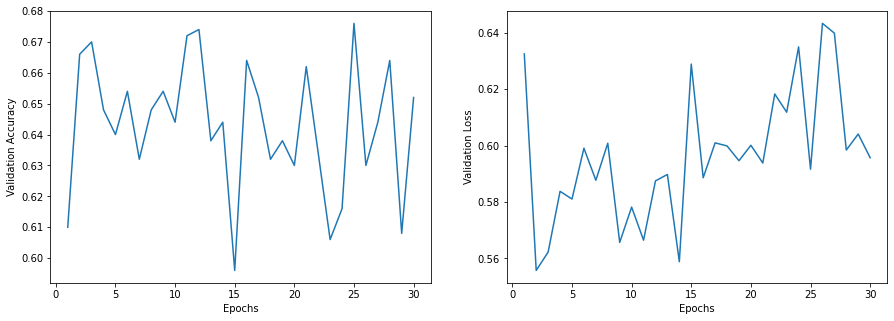

In [116]:
hists_best = run_k_fold_hps(x, y, model_best, 30, 10, 5)


In [124]:
len(hists_best[0])

50

#### Best params 1

Fold 5/50
Fold 10/50
Fold 15/50
Fold 20/50
Fold 25/50
Fold 30/50
Fold 35/50
Fold 40/50
Fold 45/50
Fold 50/50

Max Average Accuracy: 53.4% 	 Num Epochs: 27 
Min Average Loss: 0.74 	 Num Epochs: 11 


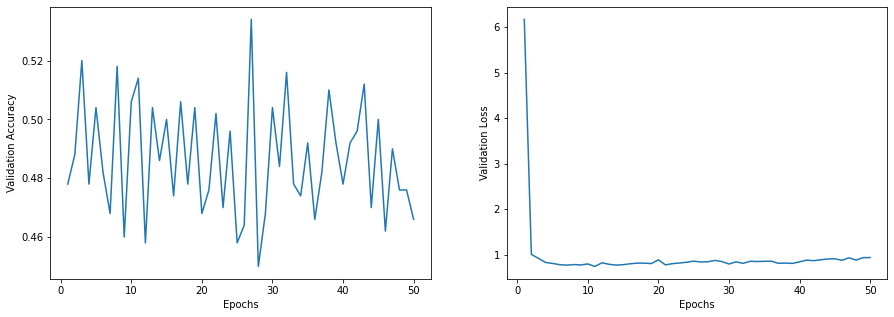

In [127]:
hists_best2 = run_k_fold_hps(x, y, build_model_2, best_hps, 50, 10, 5)

#### Best params 1

Fold 5/50
Fold 10/50
Fold 15/50
Fold 20/50
Fold 25/50
Fold 30/50
Fold 35/50
Fold 40/50
Fold 45/50
Fold 50/50

Max Average Accuracy: 55.8% 	 Num Epochs: 50 
Min Average Loss: 0.7 	 Num Epochs: 1 


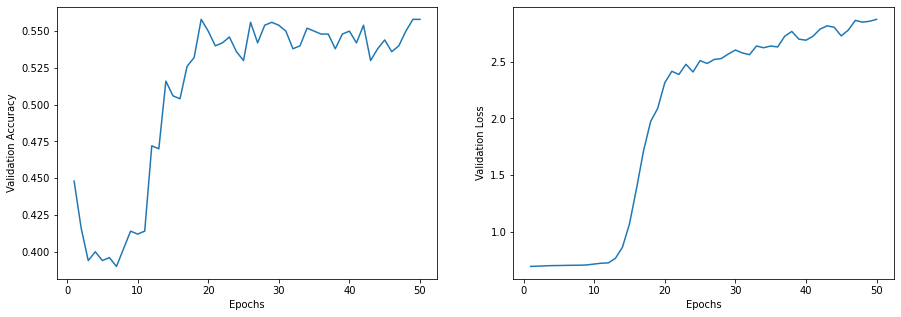

In [133]:
hists_best3 = run_k_fold_hps(x, y, build_model_2, best_hps[1], 50, 10, 5)

In [63]:
def plot_train_val_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_train_val_acc(history):
    plt.clf()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
        
    epochs = range(1, len(acc) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
        
    plt.plot(epochs, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def plot_train_val_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)
    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    # plt.plot(epochs_range, acc, label='Training Accuracy')
    # plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
 
    plt.plot(epochs_range, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, blue_dots, label='Training Loss')
    plt.plot(epochs_range, val_loss, solid_blue_line, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
  
def compare_loss_and_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['loss']), len(hist2.history['loss']))
    
    train_loss_1 = hist1['loss'][:min_epochs]
    val_loss_1 = hist1['val_loss'][:min_epochs]

    train_loss_2 = hist2['loss'][:min_epochs]
    val_loss_2 = hist2['val_loss'][:min_epochs]


    train_acc_1 = hist1['accuracy'][:min_epochs]
    val_acc_1 = hist1['val_accuracy'][:min_epochs]

    train_acc_2 = hist2['accuracy'][:min_epochs]
    val_acc_2 = hist2['val_accuracy'][:min_epochs]

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)

    plt.plot(epochs, train_loss_1, blue_dots, label = f'{title1} Training Loss')
    plt.plot(epochs, val_loss_1, solid_blue_line, label = f'{title1} Validation Loss')
    plt.plot(epochs, train_loss_2, red_dots, label = f'{title2} Training Loss')
    plt.plot(epochs, val_loss_2, solid_red_line, label = f'{title2} Validation Loss')
    # plt.title('Loss With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_1, blue_dots, label = f'{title1} Training Accuracy')
    plt.plot(epochs, val_acc_1, solid_blue_line, label = f'{title1} Validation Accuracy')
    plt.plot(epochs, train_acc_2, red_dots, label = f'{title2} Training Accuracy')
    plt.plot(epochs, val_acc_2, solid_red_line, label = f'{title2} Validation Accuracy')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

def compare_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['accuracy']), len(hist2.history['accuracy']))
    acc = hist1.history['accuracy'][:min_epochs]
    val_acc = hist1.history['val_accuracy'][:min_epochs]
    acc_drop = hist2.history['accuracy'][:min_epochs]
    val_acc_drop = hist2.history['val_accuracy'][:min_epochs]
    
    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, acc, blue_dots, label = f'{title1} Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = f'{title1} Validation Accuracy')
    plt.plot(epochs, acc_drop, red_dots, label = f'{title2} Training Accuracy')
    plt.plot(epochs, val_acc_drop, solid_red_line, label = f'{title2} Validation Accuracy')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()